# Review generation as Neural Machine Translation task

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

import re
import os
import time

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
# https://www.tensorflow.org/tutorials/text/nmt_with_attention
def preprocess_sentence(w):
    w = w.lower().strip()

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [4]:
def load_dataset(num_reviews):
    ds = tfds.load('amazon_us_reviews/Video_Games_v1_00', data_dir='/hdd/tf_datasets', 
                   split='train', shuffle_files=True).take(num_reviews)
    fields = [[i['data']['product_title'].decode("utf-8"), 
               i['data']['review_body'].decode("utf-8"), 
               i['data']['review_headline'].decode("utf-8")] for i in ds.as_numpy_iterator()
               if len(i['data']['review_body'].decode("utf-8").split('.')) > 2]
    
    x = [i[0] + ' reviewtitle ' + i[2] for i in fields]
    y = [i[1] for i in fields]

    x = [preprocess_sentence(i) for i in x]
    y = [preprocess_sentence(i) for i in y]

    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=3000, filters='', oov_token='<unk>')
    tokenizer.fit_on_texts(x + y)
    
    x = tokenizer.texts_to_sequences(x)
    y = tokenizer.texts_to_sequences(y)

    x = tf.keras.preprocessing.sequence.pad_sequences(x, padding='post')
    y = tf.keras.preprocessing.sequence.pad_sequences(y, padding='post', maxlen=100)
    
    return x, y, tokenizer

In [148]:
x, y, tokenizer = load_dataset(10)

In [150]:
def tokens_to_words(tokenizer, tensor):
    for t in tensor:
        if t != 0:
            print ("%d ----> %s" % (t, tokenizer.index_word[t]))

tokens_to_words(tokenizer, x[1])

8 ----> <start>
48 ----> elder
49 ----> scrolls
83 ----> v
31 ----> skyrim
21 ----> reviewtitle
50 ----> similar
11 ----> to
3 ----> the
51 ----> previous
84 ----> obilvion
10 ----> <end>


In [7]:
# Try experimenting with the size of that dataset
num_examples = 30000
input_tensor, target_tensor, tokenizer = load_dataset(num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [8]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

168875 168875 42219 42219


In [9]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [10]:
print ("Input Language; index to word mapping")
convert(tokenizer, input_tensor_train[3])
print ()
print ("Target Language; index to word mapping")
convert(tokenizer, target_tensor_train[3])

Input Language; index to word mapping
14 ----> <start>
737 ----> grand
937 ----> theft
692 ----> auto
25 ----> reviewtitle
134 ----> old
940 ----> school
779 ----> gta
15 ----> <end>

Target Language; index to word mapping
14 ----> <start>
37 ----> so
16 ----> this
12 ----> is
134 ----> old
940 ----> school
779 ----> gta
2 ----> .
9 ----> it
23 ----> s
30 ----> not
7 ----> a
164 ----> bad
11 ----> game
18 ----> for
9 ----> it
23 ----> s
251 ----> day
4 ----> ,
21 ----> but
9 ----> it
60 ----> has
63 ----> some
1 ----> <unk>
538 ----> age
6 ----> to
9 ----> it
103 ----> now
2 ----> .
3 ----> the
943 ----> biggest
262 ----> problem
13 ----> you
231 ----> may
290 ----> run
111 ----> into
12 ----> is
20 ----> that
13 ----> you
34 ----> can
29 ----> t
333 ----> save
9 ----> it
27 ----> on
7 ----> a
85 ----> ps
125 ----> system
2 ----> .
13 ----> you
349 ----> either
176 ----> need
7 ----> a
85 ----> ps
125 ----> system
44 ----> or
255 ----> try
6 ----> to
48 ----> play
9 ----> it
27 ----> o

### Create a tf.data dataset

In [11]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 16
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 128
units = 256
vocab_size = tokenizer.num_words

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [12]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([16, 127]), TensorShape([16, 100]))

In [13]:
vocab_size

3000

## Encoder and decoder model

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">

In [14]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units, return_sequences=True, 
                                       return_state=True, recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [15]:
encoder = Encoder(vocab_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (16, 127, 256)
Encoder Hidden state shape: (batch size, units) (16, 256)


In [16]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
                self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [17]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (16, 256)
Attention weights shape: (batch_size, sequence_length, 1) (16, 127, 1)


In [18]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units, return_sequences=True, 
                                       return_state=True, recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.gru(x)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)

        return x, state, attention_weights

In [19]:
decoder = Decoder(vocab_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (16, 3000)


## Define the optimizer and the loss function

In [20]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)

In [21]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

## Training

1. Pass the *input* through the *encoder* which return *encoder output* and the *encoder hidden state*.
2. The encoder output, encoder hidden state and the decoder input (which is the *start token*) is passed to the decoder.
3. The decoder returns the *predictions* and the *decoder hidden state*.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Use *teacher forcing* to decide the next input to the decoder.
6. *Teacher forcing* is the technique where the *target word* is passed as the *next input* to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [22]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
#             tf.print(t)
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss

In [ ]:
EPOCHS = 100

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    for (batch, (inp, targ)) in tqdm(enumerate(dataset.take(steps_per_epoch))):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

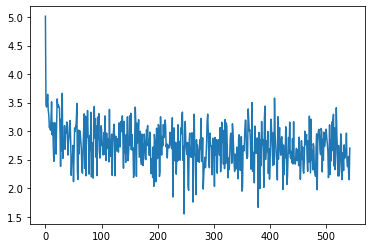

In [3]:
history = [5.0140, 3.4572, 3.4222, 3.4390, 3.6450, 3.3698, 3.2847, 3.0630, 3.0861, 3.0170, 3.2235, 3.5149, 2.9370, 3.1450, 2.7550, 2.4707, 3.1511, 2.9817, 3.1360, 2.5974, 3.1503, 3.5646, 3.4167, 3.4602, 3.4306, 3.4042, 3.0078, 2.3818, 3.2113, 2.6566, 3.6630, 2.5218, 2.8083, 2.7139, 3.0953, 2.6813, 2.9824, 2.9673, 3.1615, 3.1296, 2.5802, 2.7914, 2.8896, 3.0918, 3.1869, 2.8291, 2.2261, 2.5342, 2.5112, 2.7498, 2.1156, 2.5448, 3.0552, 2.9971, 3.0730, 3.1617, 3.4850, 2.2839, 2.1541, 3.0183, 2.6006, 3.0091, 2.9649, 2.8197, 2.6896, 2.3176, 2.2617, 2.6847, 3.0163, 3.3028, 2.3496, 3.2652, 2.2174, 3.2503, 2.8918, 3.3607, 2.9337, 2.7266, 2.2462, 2.9222, 2.6635, 3.3305, 2.1989, 2.7967, 2.5153, 2.1765, 3.1112, 3.4339, 2.8796, 3.2198, 2.5428, 3.0899, 2.2194, 3.2463, 2.8667, 3.3083, 2.6701, 2.5283, 2.6528, 3.0941, 3.0317, 2.7440, 2.7921, 2.5820, 2.9713, 2.5966, 3.2675, 2.6177, 2.4842, 2.9670, 2.6975, 2.7776, 2.8617, 2.4601, 3.3805, 2.5547, 2.5827, 2.7630, 2.9476, 2.2238, 2.7974, 2.9466, 3.1203, 2.9201, 2.2169, 2.9104, 2.9036, 2.6536, 2.8175, 2.8673, 2.6323, 3.1445, 3.0729, 2.7214, 3.1643, 2.9917, 3.1090, 3.2681, 2.8827, 2.3509, 3.1719, 2.6386, 2.7016, 2.4525, 2.9418, 2.6076, 3.2502, 2.4817, 2.6079, 2.8151, 3.2680, 2.7504, 3.3144, 2.6731, 2.9435, 2.6695, 2.7074, 2.1890, 2.2868, 2.8571, 3.4209, 3.1275, 2.2090, 3.1401, 2.7942, 3.0037, 3.2017, 2.5424, 2.7783, 2.9965, 2.5153, 2.4159, 2.9481, 2.7037, 2.3952, 2.6445, 2.9494, 2.8076, 2.5149, 2.5004, 3.0191, 2.9364, 3.0979, 2.7403, 2.8563, 2.5763, 2.9844, 2.7255, 2.2535, 2.5125, 2.4172, 2.1867, 2.7231, 2.0328, 2.9410, 2.8363, 2.1437, 2.1119, 3.0523, 2.5169, 2.5296, 3.1158, 3.0952, 2.2051, 2.2807, 3.2508, 2.8558, 2.5816, 2.9070, 2.7441, 3.1140, 2.8850, 2.9741, 3.1959, 3.0993, 2.7255, 2.7807, 2.5286, 2.7532, 2.7505, 2.7049, 2.7684, 2.9805, 2.8582, 2.7230, 2.6919, 3.2357, 1.8450, 2.8394, 3.0572, 2.5806, 2.4761, 2.8045, 2.2457, 2.6193, 2.4710, 3.1120, 2.4915, 2.8207, 2.5374, 2.4914, 3.0528, 2.9541, 3.2816, 3.3339, 2.4888, 2.7314, 1.5489, 3.0039, 3.1698, 2.7891, 2.6799, 2.5940, 2.8020, 2.0349, 1.9623, 2.7977, 2.9667, 2.5522, 2.7101, 2.5397, 2.9717, 2.7466, 1.7566, 2.8987, 3.2967, 2.5755, 2.5908, 1.8869, 2.8496, 2.4698, 2.7537, 2.6272, 2.5255, 2.4532, 2.8472, 2.6894, 3.2221, 2.4689, 2.4913, 2.8834, 1.9842, 2.2524, 2.3888, 2.5414, 2.3592, 2.5177, 2.7935, 3.1702, 3.2984, 2.9952, 2.4320, 2.3585, 2.9667, 2.7473, 2.7458, 2.7247, 2.2347, 2.8760, 2.6117, 2.6644, 2.0310, 2.8883, 2.5840, 2.7474, 2.8507, 2.2625, 2.8215, 2.8141, 2.8536, 2.5803, 3.0606, 2.2882, 2.5604, 3.1566, 2.8162, 2.9961, 2.4215, 3.0165, 2.3419, 3.2030, 2.4324, 3.1449, 3.0827, 2.5964, 2.1816, 2.5281, 2.3232, 2.4503, 2.8523, 2.9636, 2.7596, 2.4382, 3.1289, 3.0043, 2.7176, 2.4347, 2.2944, 2.5982, 2.3362, 2.3718, 2.7193, 2.3998, 2.1621, 2.8638, 2.9363, 2.8819, 2.3118, 2.8758, 2.9024, 1.9482, 2.0111, 2.7424, 2.6490, 2.6700, 2.9850, 3.1940, 3.1836, 2.6229, 2.5206, 2.5552, 3.3893, 3.2103, 2.9999, 3.0255, 2.8479, 2.3338, 2.6358, 3.5026, 2.2949, 2.6279, 2.6130, 2.0934, 3.0884, 2.6916, 2.6115, 2.6183, 2.8814, 2.5864, 1.6622, 2.9778, 2.9706, 1.9948, 2.8418, 2.3939, 3.1689, 2.7561, 2.8554, 2.6163, 2.0151, 3.2368, 3.4385, 2.5018, 2.6888, 2.8310, 2.6397, 2.9942, 2.2573, 2.6901, 2.1585, 2.3682, 3.0447, 3.2087, 2.9445, 2.7010, 2.3967, 2.9753, 2.4131, 3.5784, 2.9561, 2.7683, 2.5840, 2.4624, 2.1438, 3.2525, 2.5095, 2.9083, 3.0620, 2.7020, 2.5792, 2.8547, 2.9019, 2.7126, 1.9784, 2.7581, 2.2377, 2.5620, 2.5346, 3.0764, 2.9374, 2.0654, 2.1933, 2.5715, 2.8888, 2.6092, 3.1587, 2.5494, 2.5165, 2.6456, 2.4435, 2.8691, 2.4241, 3.1660, 2.4343, 2.4762, 2.4235, 2.5862, 2.6991, 2.4829, 2.6691, 2.6616, 2.3940, 2.8948, 2.4731, 2.1566, 2.4225, 2.8314, 2.5054, 2.7224, 2.3029, 2.2626, 2.4741, 2.9988, 2.7631, 2.8265, 2.9401, 2.5181, 2.2964, 2.8348, 2.4563, 3.2627, 2.7320, 2.2685, 3.2093, 2.4935, 2.6603, 2.3238, 2.7796, 2.7360, 2.2969, 2.2679, 2.2086, 2.7106, 2.9517, 1.9722, 2.8216, 2.9929, 3.0316, 2.9155, 2.6686, 2.5875, 3.0464, 2.9945, 2.2840, 2.8581, 2.4881, 2.9822, 2.7308, 2.8182, 2.8945, 3.0339, 2.8834, 2.7892, 2.6382, 2.1847, 2.2903, 3.1099, 2.2404, 2.8456, 2.4792, 3.1609, 2.6604, 3.1956, 3.2956, 2.3900, 3.0561, 2.3246, 2.6060, 3.4091, 2.9263, 2.6486, 2.2146, 2.7493, 2.2149, 2.3052, 2.5364, 2.9521, 2.8087, 2.1504, 2.6174, 2.5426, 2.3087, 2.7592, 2.5255, 2.6740, 2.6257, 2.9647, 2.4709, 2.3770, 2.5555, 2.2525, 2.1482, 2.7035]
plt.plot(np.arange(len(history)), history)

## Translate

* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*.

Note: The encoder output is calculated only once for one input.

In [24]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result += tokenizer.index_word[predicted_id] + ' '

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [25]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [26]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

## Restore the latest checkpoint and test

In [27]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [32]:
translate(u'turtle reviewtitle i hate it')

Input: <start> turtle reviewtitle i hate it <end>
Predicted translation: i have to say that the <unk> is <unk> . i have to say that the <unk> is <unk> . i have to say that the <unk> is <unk> . i have to say that the <unk> is <unk> . i have to say that the <unk> is <unk> . i have to say that the <unk> is <unk> . i have to say that the <unk> is <unk> . i have to say that the <unk> is <unk> . i have to say that the <unk> is <unk> . i have to say that the <unk> is <unk> . 


In [33]:
translate(u'game reviewtitle good game this is')

Input: <start> game reviewtitle good game this is <end>
Predicted translation: i bought this game for my son . he loves it . <end> 


In [38]:
translate(u'game of blocks reviewtitle awful')

Input: <start> game of blocks reviewtitle awful <end>
Predicted translation: i was hoping for a <unk> . <end> 


In [39]:
translate(u'game of blocks reviewtitle good but bad')

Input: <start> game of blocks reviewtitle good but bad <end>
Predicted translation: i bought this game for my son . he loves it . <end> 


# Beam search on results

In [144]:
def beam_search(sentence, guesses_number, width=100):
    sentence = preprocess_sentence(sentence)

    inputs = [tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = int(tokenizer.word_index['<start>'])

    top_guesses = []
    current_guesses = [[[dec_input], tf.identity(dec_hidden), 0]]
    for t in range(max_length_targ):
        current_guesses_expanded = []
        # Iterate over all current coditions
        for guess in current_guesses:
            dec_input = tf.expand_dims([guess[0][-1]], 0)
            predictions, dec_hidden, _ = decoder(dec_input, guess[1], enc_out)
            predictions = tf.nn.softmax(predictions[0])
            
            top_ids = tf.argsort(predictions, direction='DESCENDING')[:width]
            scores = guess[2] + tf.math.log(tf.clip_by_value(tf.gather(predictions, top_ids), 0.001, 1))
            
            # Add new word ids
            word_ids = [guess[0] + [int(id)] for id in top_ids]

            current_guesses_expanded += list(np.array([word_ids, 
                                                       [dec_hidden] * width, 
                                                       scores.numpy().tolist()]).T)
        
        current_guesses = sorted(current_guesses_expanded, key=lambda x: -x[2])[:width]
        
        # Add guess to top_guesses if encounter <end> token
        done_idxs = [guess_idx for guess_idx in range(len(current_guesses))
                     if tokenizer.index_word[int(current_guesses[guess_idx][0][-1])] == '<end>']
        done_guesses = np.take(current_guesses, done_idxs, axis=0)
        # Normalize score by length
        done_guesses = [[guess[0], guess[2] / (t+1)] for guess in done_guesses]
        top_guesses += done_guesses
        current_guesses = [guess for idx, guess in enumerate(current_guesses)
                           if idx not in done_idxs]
        
        if len(current_guesses) == 0 or len(top_guesses) >= guesses_number:
            break
    
    top_guesses.sort(key=lambda x: -x[1])
    for i, guess in enumerate(top_guesses):
        top_guesses[i][0] = ' '.join(tokenizer.index_word[predicted_id] for predicted_id in guess[0])
    return top_guesses

In [146]:
for string in [u'turtle reviewtitle i hate it',
               u'game reviewtitle good game this is',
               u'game of blocks reviewtitle awful',
               u'fly and jump game reviewtitle i am in love']:
    print(string)
    display(beam_search(string, guesses_number=10, width=100))
    print()

turtle reviewtitle i hate it


[['<start> . . . . . <end>', -1.679051399230957],
 ['<start> i am very disappointed . <end>', -1.689155101776123],
 ['<start> i was very disappointed . <end>', -1.6988743146260579],
 ['<start> i love it . <end>', -1.7169036865234375],
 ['<start> my son loves it . <end>', -1.7271722157796223],
 ['<start> i love this game . <end>', -1.7296597162882488],
 ['<start> i love this product . <end>', -1.73617951075236],
 ['<start> i really like it . <end>', -1.7708751360575359],
 ['<start> this is the best . <end>', -1.7916747728983562],
 ['<start> i gave it stars . <end>', -1.7940155665079753],
 ['<start> . . . . <end>', -1.850620651245117],
 ['<start> i was disappointed . <end>', -1.8532413482666015],
 ['<start> i like it . <end>', -1.8768302917480468],
 ['<start> in my opinion . <end>', -1.9378265380859374],
 ['<start> . . . <end>', -1.9929485321044922],
 ['<start> <unk> . <end>', -2.32921568552653],
 ['<start> . <end>', -3.0107967853546143]]


game reviewtitle good game this is


[['<start> i love this game . <end>', -1.162440299987793],
 ['<start> this game is great . <end>', -1.3510438601175945],
 ['<start> my son loves it . <end>', -1.3648900985717773],
 ['<start> i like this game . <end>', -1.380246639251709],
 ['<start> this game is fun . <end>', -1.4325199127197266],
 ['<start> this game is awesome . <end>', -1.4501268068949382],
 ['<start> i loved this game . <end>', -1.4728185335795085],
 ['<start> i love it . <end>', -1.628084373474121],
 ['<start> great game . <end>', -1.7155342102050781],
 ['<start> good game . <end>', -1.88535475730896],
 ['<start> . <end>', -3.3083176612854004]]


game of blocks reviewtitle awful


[['<start> this game is awful . <end>', -1.4846069018046062],
 ['<start> this game is terrible . <end>', -1.5105679829915364],
 ['<start> i love this game . <end>', -1.5400606791178386],
 ['<start> this game sucks . <end>', -1.5434709548950196],
 ['<start> this game is horrible . <end>', -1.5518356959025066],
 ['<start> i loved this game . <end>', -1.6526637077331543],
 ['<start> this game is <unk> . <end>', -1.677598476409912],
 ['<start> i like this game . <end>', -1.7000528971354167],
 ['<start> i was very disappointed . <end>', -1.7126693725585938],
 ['<start> this game was awful . <end>', -1.7172053654988606],
 ['<start> . . . . . <end>', -1.722913106282552],
 ['<start> this game is great . <end>', -1.729897181193034],
 ['<start> this game sucks ! <end>', -1.7871707916259765],
 ['<start> . . . <end>', -2.0473437309265137],
 ['<start> terrible game . <end>', -2.104079484939575],
 ['<start> <unk> . <end>', -2.3905003865559897],
 ['<start> . <end>', -3.282750129699707]]


fly and jump game reviewtitle i am in love


[['<start> i love this game . <end>', -1.1592001914978027],
 ['<start> i love this game ! <end>', -1.4713856379191081],
 ['<start> i love this product . <end>', -1.4784666697184246],
 ['<start> this game is great . <end>', -1.499791145324707],
 ['<start> i love this program . <end>', -1.5230175654093425],
 ['<start> i love it . <end>', -1.534067440032959],
 ['<start> this game is awesome . <end>', -1.5387899080912273],
 ['<start> this game is amazing . <end>', -1.5510603586832683],
 ['<start> i love it ! <end>', -1.6734235763549805],
 ['<start> . <end>', -3.415926218032837]]

#### It looks at condition!